# Multi-head Attention

In [3]:
import torch
import torch.nn.functional as F

n_samples = 20000
n_features = 24

event = torch.multinomial(torch.tensor([0.5,0.2,0.2,0.1]), num_samples=n_samples, replacement=True)
event_one_hot = F.one_hot(event, num_classes=4)
dir = torch.multinomial(torch.tensor([0.5,0.5]), num_samples=n_samples, replacement=True)
other = torch.randn(n_samples, n_features - 5)

X_train = torch.cat([event_one_hot.float(), dir.unsqueeze(1).float(), other], dim=1)

Epoch 1/5


100%|██████████| 200/200 [00:04<00:00, 45.20it/s]


Epoch 2/5


100%|██████████| 200/200 [00:04<00:00, 45.28it/s]


Epoch 3/5


100%|██████████| 200/200 [00:04<00:00, 40.00it/s]


Epoch 4/5


100%|██████████| 200/200 [00:04<00:00, 49.13it/s]


Epoch 5/5


100%|██████████| 200/200 [00:02<00:00, 93.08it/s] 


Event Accuracy: 1.0000


100%|██████████| 200/200 [00:01<00:00, 103.33it/s]

Dir Accuracy: 0.9999


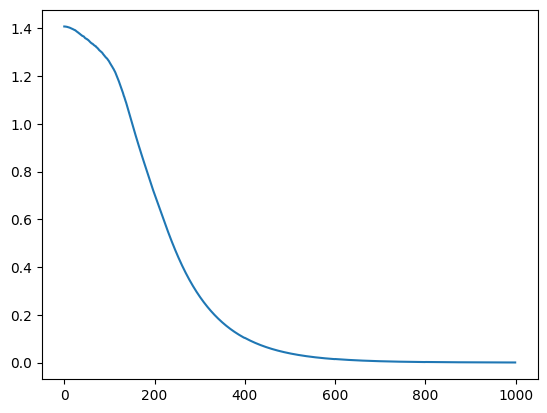

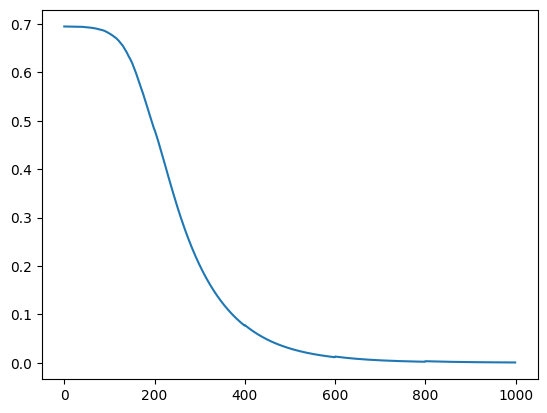

In [ ]:
from torch.nn import MultiheadAttention, Linear
from tqdm import tqdm
import matplotlib.pyplot as plt

class ExponentialMovingAverage:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.moving_avg = None
    
    def update(self, value):
        if self.moving_avg is None:
            self.moving_avg = value
        else:
            self.moving_avg = self.alpha * value + (1 - self.alpha) * self.moving_avg
    
    def get_average(self):
        return self.moving_avg

# Usage
event_ema = ExponentialMovingAverage(alpha=0.01)
dir_ema = ExponentialMovingAverage(alpha=0.01)

attn_model = MultiheadAttention(embed_dim=n_features, num_heads=4)


def get_attn_score(start, end):
    target_len = end - start
    attn_mask = torch.triu(torch.ones(target_len, n_samples), diagonal=start+1).bool()
    score = attn_model(X_train[start:end, :], X_train, X_train, attn_mask=attn_mask, is_causal=True)
    return score 

a = get_attn_score(100, 200)
# a[0].shape = [100, 24]
# a[1].shape = [100, n_samples]

event_linear = Linear(n_features, 4)
dir_linear = Linear(n_features, 1)
attn_model.requires_grad_()
event_linear.requires_grad_()
criterion_event = torch.nn.CrossEntropyLoss()
criterion_dir = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(list(attn_model.parameters()) + list(event_linear.parameters()), lr=0.001)
n_epochs = 5
event_losses = []
dir_losses = []

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    for i in tqdm(range(0, n_samples, 100)):
        start = i
        end = min(i + 100, n_samples)
        attn_output = get_attn_score(start, end)[0]
        event_logits = event_linear(attn_output)
        event_loss = criterion_event(event_logits, event[start:end])
        event_ema.update(event_loss.item())
        event_losses.append(event_ema.get_average())
        dir_logits = dir_linear(attn_output).squeeze()
        dir_loss = criterion_dir(dir_logits, dir[start:end].float())
        dir_ema.update(dir_loss.item())
        dir_losses.append(dir_ema.get_average())
        loss = event_loss + dir_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# evaluate event
with torch.no_grad():
    correct = 0
    total = 0
    for i in tqdm(range(0, n_samples, 100)):
        start = i
        end = min(i + 100, n_samples)
        attn_output = get_attn_score(start, end)[0]
        event_logits = event_linear(attn_output)
        _, predicted = torch.max(event_logits, dim=1)
        total += (end - start)
        correct += (predicted == event[start:end]).sum().item()

    accuracy = correct / total
    print(f'Event Accuracy: {accuracy:.4f}')


# evaluate dir
with torch.no_grad():
    correct = 0
    total = 0
    for i in tqdm(range(0, n_samples, 100)):
        start = i
        end = min(i + 100, n_samples)
        attn_output = get_attn_score(start, end)[0]
        dir_logits = dir_linear(attn_output).squeeze()
        predicted = (torch.sigmoid(dir_logits) > 0.5).float()
        total += (end - start)
        correct += (predicted == dir[start:end].float()).sum().item()

    accuracy = correct / total
    print(f'Dir Accuracy: {accuracy:.4f}')

plt.figure()
plt.plot(event_losses)
plt.figure()
plt.plot(dir_losses)


In [10]:
torch.triu(torch.ones(5, 10), diagonal=2)

tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.]])

tensor(3)